In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical, Normal
from torchsummary import summary
import pickle
import os
import gym
from gym.wrappers import Monitor
from tqdm import tqdm
import numpy as np
import time
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from pathlib import Path
from IPython.display import clear_output
import random, os.path, math, glob, csv, base64, itertools, sys
import matplotlib.pyplot as plt

display = Display(visible=0, size=(1400, 900))
display.start();

In [50]:
def to_tensor(x):
    """Convert array into pytorch tensor"""

    if not isinstance(x, np.ndarray):
        x = np.array(x)

    return torch.from_numpy(x).float()

def to_numpy(x):
    """Convert tensor into numpy array"""
    return x.numpy()

In [3]:
class FlexibleDenseNet(nn.Module):
    def __init__(self, layers=[64,32,16,8,4], activations=nn.ReLU, last_activation=None):
        '''Initialize flexible (by list of dimensions defined) densely connected network module.'''
        # Save the model structure
        self.model = nn.ModuleList()
        # Plan the activations - will be an activation function or None in case of no activation layer wanted
        activ = ([activations] * len(layers) - 1)
        activ.append(last_activation)
        # Create layers
        for i, layer in enumerate(layers[-1:]):
            self.model.append(nn.Linear(layers[i], layers[i+1]))
            if activ[i]:
                self.model.append(activ[i]())
        
        def forward(self, x):
            # Iterate through each layer of model, return the last value
            for layer in self.model:
                x = layer(x)
            return x
        

class ActorCritic(nn.Module):
    def __init__(self, observation_space, action_space, hidden_layers=[512, 512, 256],
                 policy_layers=[32, 8], value_layers=[32, 8], policy_activation=nn.Softmax,
                 value_activation=None, activations=nn.ReLU):
        super().__init__()
        # Initialize the common model
        self.model = FlexibleDenseNet(hidden_layers, activations=activations, last_activation=activations)
        # Initialize policy submodel
        self.policy = FlexibleDenseNet(policy_layers, activations=activations, last_activation=policy_activation)
        # Endpoint for values
        self.value = FlexibleDenseNet(value_layers, activations=activations, last_activation=value_activation)
        
    def forward(self, x):
        # Apply common model
        common = self.model(x)
        # Policy
        p = self.policy(common)
        # Value
        v = self.value(common)
        return v, p

In [45]:
class Agent:
    def __init__(self, lr=0.0003, gamma=0.995, environment="Pendulum-v1", beta=0.05,
                 discrete=False, sample_std=0.1, h=[], p=[], v=[], gyms=16):
        self.beta = beta                                  # Beta for entropy (actor loss)
        self.lr = lr                                      # Learning rate
        self.gamma = gamma                                # Gamma for discounting late actions
        self.env = gym.make(environment)                  # Init env
        self.discrete = discrete                          # Discrete env
        self.best = None                                  # Path to best model (highest reward)
        
        self.sample_std = sample_std if sample_std else 0.04         # STD for sampling action from policy distribution
        self.observation_space = self.env.observation_space.shape[0] # Env output vector size
        # Actuator vector size
        self.n_actions = self.env.action_space.n if self.discrete else self.env.action_space.shape[0]
        # Monitor wrapper to see the env
        self.monitor_env = Monitor(self.env, "./videos", force=True, video_callable=lambda episode: True)

        # Initialize actor-critic and it's optimizer
        self.actor_critic = ActorCritic(self.observation_space, self.n_actions,
                                       policy_layers=p, value_layers=v, hidden_layers=h)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), self.lr)

    def unpickle_self(cls, path):
        '''Unpickle self from provided path'''
        with open(path, "rb") as pfile:
            self = pickle.load(pfile)
        
    def load_best(self):
        '''Loads weights of best NN this object experienced'''
        self.load_weights(self.best)
        
    def load_weights(self, path):
        '''Load weights from provided path'''
        # Load weights
        weights_new = torch.load(path)
        # Initialize new model, load it's new weights and reinitialize optimizer
        self.actor_critic = ActorCritic(self.observation_space, self.n_actions)
        self.actor_critic.load_state_dict(weights_new)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), self.lr)
        
    def save_model(self, path="basic", directory="models", selfpickle=False):
        '''Save model (as NN params or pickle of Agent)'''
        # Create topdir
        os.makedirs(directory, exist_ok=True)
        if selfpickle:       # Pickle object
            with open(os.path.join(directory, path + ".p"), "wb") as pfile:
                pickle.dump(self, pfile)
            return os.path.join(directory, path + ".p")
        else:                # Pickle neural network
            torch.save(self.actor_critic.state_dict(), os.path.join(directory, path))
            return os.path.join(directory, path)
    
    def save_video(self):
        '''Save or show video of agent trying its best'''
        self.run(epochs=1,train=False,visualize=True)
        print(f"Reward: {self.history['score'][-1]}")
        html = []
        for mp4 in Path('./videos').glob("*.mp4"):
            video_b64 = base64.b64encode(mp4.read_bytes())
            html.append('''<video alt="{}" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{}" type="video/mp4" />
                    </video>'''.format(mp4, video_b64.decode('ascii')))
        ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
    
    def choose_action(self, observation):
        '''Choose next action based on observation'''
        # Get actions from actor-critic
        state = to_tensor(observation.reshape(-1, 1, self.observation_space))
        _, policy = self.actor_critic(state)
        # Categorical for discreet env, distribution over probability for continuous env
        if self.discrete:
            action_probabilities = Categorical(policy)
        else:
            action_probabilities = Normal(policy, self.sample_std)
        # Sample from distribution and store the action
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action
        # Reduce dimensions
        return action.numpy()[0]
    

    def learn(self, state, state_, reward, done):
        '''Perform single learning step'''
        # Adjust types and sizes
        state, state_, reward = to_tensor(state), to_tensor(state_), to_tensor(reward)
        state = state.reshape(-1, 1, self.observation_space)
        state_ = state_.reshape(-1, 1, self.observation_space)
        
        # Inference NN and reduce dimensions of it's result
        state_val, policy = self.actor_critic(state)
        state_val_, _ = self.actor_critic(state_)
        state_val = state_val[0]
        state_val_ = state_val_[0]
        
        # Handle descrete and continuous
        if self.discrete:
            policy_distribution =  Categorical(policy)
        else:
            policy_distribution = Normal(policy, self.sample_std)
        # Caluclate loss/gradients
        log_policy = policy_distribution.log_prob(self.action)
        entropy = policy_distribution.entropy().mean()

        delta = reward + self.gamma * state_val_ * (1 - int(done)) - state_val
        actor_loss = - log_policy * delta - entropy * self.beta
        critic_loss = delta ** 2
        total_loss = actor_loss + critic_loss
        
        # Apply gradients
        self.optimizer.zero_grad()
        total_loss.backward()
        # Restrain gradients
        nn.utils.clip_grad_norm_([p for g in self.optimizer.param_groups for p in g["params"]], 0.5)
        self.optimizer.step()
    
    def run(self, epochs=200, max_steps=128, train=True, visualize=False, dirs="kokos1"):
        '''Run inference in loops - evaluation or training'''
        # MEMORY
        self.history = {
            "score": [],
        }
        cache = []
        max_reward = float('-inf')
        # Visualization wrapper
        env = self.monitor_env if visualize else self.env

        for epoch in tqdm(range(epochs)):
            observation = env.reset()    # For each epoch - reset env
            done = False                 # Agent not done
            rewards = 0                  # Cumulative rewards per epoch
            while not done:
                # Choose action to perform -> step the env
                action = self.choose_action(observation)
                observation_, reward, done, info = env.step(action[0])
                rewards += reward
                if train:    # Apply training if required
                    self.learn(observation, observation_, reward, done)
                observation = observation_
            # Keep track of best reward agent
            if rewards >= max_reward:
                max_reward = rewards
                self.best = self.save_model(path=f"e{epoch}_r{rewards}", selfpickle=False, directory=dirs)
            # Some printing, clearing cache
            self.history["score"].append(rewards)
            cache.append(rewards)
            if not ((epoch + 1) % 50):  
                print(f'Run {epoch + 1}. - reward: {int(sum(cache)/len(cache))}')
                cache.clear()
        env.close()
        return self.history

In [18]:
agent00 = Agent(environment="CartPole-v1", discrete=True, gamma=0.997, beta=0.1, h=[512, 256], p=[], v=[])
agent00.run(epochs=5000, dirs="test00")

  1%|▍                                        | 51/5000 [00:03<09:10,  9.00it/s]

Run 50. - reward: 28


  2%|▊                                       | 101/5000 [00:08<09:42,  8.41it/s]

Run 100. - reward: 32


  3%|█▏                                      | 151/5000 [00:13<12:44,  6.35it/s]

Run 150. - reward: 43


  4%|█▌                                      | 201/5000 [00:18<09:08,  8.74it/s]

Run 200. - reward: 32


  5%|██                                      | 252/5000 [00:25<08:45,  9.03it/s]

Run 250. - reward: 53


  6%|██▍                                     | 301/5000 [00:30<07:17, 10.75it/s]

Run 300. - reward: 46


  7%|██▊                                     | 351/5000 [00:36<05:28, 14.14it/s]

Run 350. - reward: 40


  8%|███▏                                    | 401/5000 [00:42<12:44,  6.02it/s]

Run 400. - reward: 53


  9%|███▌                                    | 450/5000 [00:51<16:50,  4.50it/s]

Run 450. - reward: 68


 10%|████                                    | 501/5000 [01:00<23:31,  3.19it/s]

Run 500. - reward: 70


 11%|████▍                                   | 550/5000 [01:09<21:59,  3.37it/s]

Run 550. - reward: 45


 12%|████▊                                   | 601/5000 [01:23<11:03,  6.63it/s]

Run 600. - reward: 64


 13%|█████▏                                  | 651/5000 [01:36<12:27,  5.82it/s]

Run 650. - reward: 69


 14%|█████▌                                  | 703/5000 [01:54<10:15,  6.98it/s]

Run 700. - reward: 104


 15%|██████                                  | 750/5000 [02:05<10:46,  6.57it/s]

Run 750. - reward: 84


 16%|██████▍                                 | 800/5000 [02:18<11:25,  6.13it/s]

Run 800. - reward: 70


 17%|██████▊                                 | 850/5000 [02:38<18:47,  3.68it/s]

Run 850. - reward: 85


 18%|██████▊                               | 900/5000 [03:07<1:12:39,  1.06s/it]

Run 900. - reward: 166


 19%|███████▌                                | 952/5000 [03:21<13:35,  4.96it/s]

Run 950. - reward: 98


 20%|███████▊                               | 1000/5000 [03:38<13:34,  4.91it/s]

Run 1000. - reward: 71


 21%|████████▏                              | 1050/5000 [03:53<25:35,  2.57it/s]

Run 1050. - reward: 65


 22%|████████▌                              | 1101/5000 [04:10<24:46,  2.62it/s]

Run 1100. - reward: 67


 23%|████████▉                              | 1151/5000 [04:25<12:09,  5.28it/s]

Run 1150. - reward: 93


 24%|█████████▎                             | 1200/5000 [04:52<26:32,  2.39it/s]

Run 1200. - reward: 134


 25%|█████████▊                             | 1250/5000 [05:21<24:45,  2.53it/s]

Run 1250. - reward: 120


 26%|██████████▏                            | 1301/5000 [05:36<13:38,  4.52it/s]

Run 1300. - reward: 88


 27%|██████████▌                            | 1350/5000 [05:52<11:05,  5.49it/s]

Run 1350. - reward: 79


 28%|██████████▉                            | 1404/5000 [06:43<11:15,  5.32it/s]

Run 1400. - reward: 239


 29%|███████████▎                           | 1452/5000 [07:08<06:59,  8.46it/s]

Run 1450. - reward: 85


 30%|███████████▋                           | 1500/5000 [07:12<05:13, 11.17it/s]

Run 1500. - reward: 11


 31%|████████████                           | 1551/5000 [07:37<08:49,  6.51it/s]

Run 1550. - reward: 72


 32%|████████████▍                          | 1601/5000 [08:04<25:40,  2.21it/s]

Run 1600. - reward: 84


 33%|████████████▉                          | 1651/5000 [08:21<27:00,  2.07it/s]

Run 1650. - reward: 61


 34%|████████████▌                        | 1700/5000 [08:52<1:25:36,  1.56s/it]

Run 1700. - reward: 90


 35%|█████████████▋                         | 1750/5000 [09:26<53:17,  1.02it/s]

Run 1750. - reward: 104


 36%|██████████████                         | 1801/5000 [09:46<05:09, 10.34it/s]

Run 1800. - reward: 74


 37%|██████████████▍                        | 1850/5000 [10:21<30:41,  1.71it/s]

Run 1850. - reward: 96


 38%|██████████████▊                        | 1900/5000 [10:46<12:45,  4.05it/s]

Run 1900. - reward: 74


 39%|███████████████▏                       | 1950/5000 [11:11<09:04,  5.60it/s]

Run 1950. - reward: 89


 40%|██████████████▊                      | 2001/5000 [12:05<1:19:24,  1.59s/it]

Run 2000. - reward: 158


 41%|████████████████                       | 2053/5000 [12:29<03:12, 15.35it/s]

Run 2050. - reward: 67


 42%|████████████████▍                      | 2101/5000 [12:45<07:00,  6.90it/s]

Run 2100. - reward: 50


 43%|████████████████▊                      | 2152/5000 [13:19<09:13,  5.15it/s]

Run 2150. - reward: 136


 44%|█████████████████▏                     | 2201/5000 [13:38<10:41,  4.36it/s]

Run 2200. - reward: 58


 45%|█████████████████▌                     | 2250/5000 [13:58<55:35,  1.21s/it]

Run 2250. - reward: 71


 46%|█████████████████▉                     | 2300/5000 [14:19<26:12,  1.72it/s]

Run 2300. - reward: 64


 47%|██████████████████▎                    | 2352/5000 [15:08<27:46,  1.59it/s]

Run 2350. - reward: 158


 48%|██████████████████▋                    | 2401/5000 [15:31<09:30,  4.56it/s]

Run 2400. - reward: 66


 49%|███████████████████                    | 2450/5000 [16:10<26:13,  1.62it/s]

Run 2450. - reward: 110


 50%|███████████████████▌                   | 2500/5000 [16:41<19:13,  2.17it/s]

Run 2500. - reward: 86


 51%|███████████████████▉                   | 2550/5000 [17:04<51:46,  1.27s/it]

Run 2550. - reward: 63


 52%|████████████████████▎                  | 2600/5000 [17:38<43:27,  1.09s/it]

Run 2600. - reward: 110


 53%|████████████████████▋                  | 2650/5000 [18:03<09:27,  4.14it/s]

Run 2650. - reward: 96


 54%|█████████████████████                  | 2701/5000 [18:22<19:48,  1.94it/s]

Run 2700. - reward: 90


 55%|█████████████████████▍                 | 2751/5000 [18:42<05:10,  7.24it/s]

Run 2750. - reward: 70


 56%|█████████████████████▊                 | 2800/5000 [19:06<24:49,  1.48it/s]

Run 2800. - reward: 88


 57%|██████████████████████▎                | 2854/5000 [19:27<06:49,  5.24it/s]

Run 2850. - reward: 85


 58%|██████████████████████▌                | 2899/5000 [19:41<06:22,  5.50it/s]

Run 2900. - reward: 73


 59%|███████████████████████                | 2950/5000 [20:05<05:42,  5.99it/s]

Run 2950. - reward: 85


 60%|███████████████████████▍               | 3002/5000 [20:33<12:03,  2.76it/s]

Run 3000. - reward: 96


 61%|███████████████████████▊               | 3051/5000 [20:54<06:29,  5.00it/s]

Run 3050. - reward: 89


 62%|████████████████████████▏              | 3101/5000 [21:12<06:23,  4.95it/s]

Run 3100. - reward: 85


 63%|████████████████████████▌              | 3151/5000 [21:32<06:46,  4.54it/s]

Run 3150. - reward: 70


 64%|████████████████████████▉              | 3201/5000 [21:55<07:06,  4.21it/s]

Run 3200. - reward: 81


 65%|█████████████████████████▎             | 3250/5000 [22:17<18:21,  1.59it/s]

Run 3250. - reward: 91


 66%|█████████████████████████▋             | 3301/5000 [22:37<15:22,  1.84it/s]

Run 3300. - reward: 91


 67%|██████████████████████████▏            | 3350/5000 [22:58<04:51,  5.67it/s]

Run 3350. - reward: 74


 68%|██████████████████████████▌            | 3402/5000 [23:21<06:08,  4.34it/s]

Run 3400. - reward: 82


 69%|██████████████████████████▉            | 3448/5000 [23:36<03:36,  7.15it/s]

Run 3450. - reward: 62


 70%|███████████████████████████▎           | 3500/5000 [23:51<09:23,  2.66it/s]

Run 3500. - reward: 79


 71%|███████████████████████████▋           | 3550/5000 [24:27<07:19,  3.30it/s]

Run 3550. - reward: 127


 72%|████████████████████████████           | 3601/5000 [24:48<06:31,  3.57it/s]

Run 3600. - reward: 73


 73%|████████████████████████████▍          | 3652/5000 [25:04<02:31,  8.92it/s]

Run 3650. - reward: 68


 74%|████████████████████████████▊          | 3700/5000 [25:21<12:04,  1.80it/s]

Run 3700. - reward: 84


 75%|█████████████████████████████▎         | 3751/5000 [25:47<04:35,  4.53it/s]

Run 3750. - reward: 92


 76%|█████████████████████████████▌         | 3790/5000 [26:12<08:22,  2.41it/s]


KeyboardInterrupt: 

In [52]:
agent00 = Agent(environment="Pendulum-v1", discrete=False, gamma=0.99999, beta=0.1, h=[256, 128, 64], p=[32], v=[32])
agent00.run(epochs=5000, dirs="test_pendulum00")

  1%|▍                                        | 50/5000 [00:25<42:11,  1.96it/s]

Run 50. - reward: -1301


  2%|▊                                       | 100/5000 [00:52<45:56,  1.78it/s]

Run 100. - reward: -1308


  3%|█▏                                    | 150/5000 [01:37<1:21:23,  1.01s/it]

Run 150. - reward: -1342


  4%|█▌                                      | 200/5000 [02:17<45:35,  1.75it/s]

Run 200. - reward: -1370


  5%|█▉                                    | 250/5000 [03:00<1:17:11,  1.03it/s]

Run 250. - reward: -1298


  6%|██▍                                     | 300/5000 [03:42<42:35,  1.84it/s]

Run 300. - reward: -1302


  7%|██▋                                   | 350/5000 [04:25<1:24:23,  1.09s/it]

Run 350. - reward: -1319


  8%|███                                   | 400/5000 [05:16<1:13:46,  1.04it/s]

Run 400. - reward: -1307


  9%|███▌                                    | 450/5000 [05:53<46:17,  1.64it/s]

Run 450. - reward: -1280


 10%|███▊                                  | 500/5000 [06:47<1:22:25,  1.10s/it]

Run 500. - reward: -1362


 11%|████▍                                   | 550/5000 [07:32<46:31,  1.59it/s]

Run 550. - reward: -1392


 12%|████▌                                 | 600/5000 [08:14<1:11:15,  1.03it/s]

Run 600. - reward: -1342


 13%|█████▏                                  | 650/5000 [08:57<56:35,  1.28it/s]

Run 650. - reward: -1406


 14%|█████▎                                | 700/5000 [09:46<1:06:34,  1.08it/s]

Run 700. - reward: -1358


 15%|██████                                  | 750/5000 [10:23<45:17,  1.56it/s]

Run 750. - reward: -1406


 16%|██████                                | 800/5000 [11:11<1:02:24,  1.12it/s]

Run 800. - reward: -1350


 17%|██████▊                                 | 850/5000 [11:44<54:12,  1.28it/s]

Run 850. - reward: -1326


 18%|██████▊                               | 900/5000 [12:31<1:02:25,  1.09it/s]

Run 900. - reward: -1336


 19%|███████▏                              | 950/5000 [13:05<1:04:49,  1.04it/s]

Run 950. - reward: -1324


 20%|███████▍                             | 1000/5000 [13:52<1:04:08,  1.04it/s]

Run 1000. - reward: -1358


 21%|████████▏                              | 1050/5000 [14:28<59:54,  1.10it/s]

Run 1050. - reward: -1294


 22%|████████▌                              | 1100/5000 [15:07<36:28,  1.78it/s]

Run 1100. - reward: -1345


 23%|████████▌                            | 1150/5000 [15:48<1:00:19,  1.06it/s]

Run 1150. - reward: -1334


 24%|█████████▎                             | 1200/5000 [16:29<36:06,  1.75it/s]

Run 1200. - reward: -1358


 25%|█████████▊                             | 1250/5000 [17:07<54:59,  1.14it/s]

Run 1250. - reward: -1371


 26%|██████████▏                            | 1300/5000 [17:42<35:55,  1.72it/s]

Run 1300. - reward: -1326


 27%|██████████▌                            | 1350/5000 [18:25<57:22,  1.06it/s]

Run 1350. - reward: -1366


 28%|██████████▉                            | 1400/5000 [19:01<34:03,  1.76it/s]

Run 1400. - reward: -1306


 29%|███████████▎                           | 1450/5000 [19:45<53:49,  1.10it/s]

Run 1450. - reward: -1343


 30%|███████████▋                           | 1500/5000 [20:25<42:10,  1.38it/s]

Run 1500. - reward: -1308


 31%|████████████                           | 1550/5000 [21:16<37:51,  1.52it/s]

Run 1550. - reward: -1302


 32%|████████████▍                          | 1600/5000 [21:46<49:52,  1.14it/s]

Run 1600. - reward: -1307


 33%|████████████▊                          | 1650/5000 [22:34<33:32,  1.66it/s]

Run 1650. - reward: -1343


 34%|█████████████▎                         | 1700/5000 [23:12<52:26,  1.05it/s]

Run 1700. - reward: -1271


 35%|█████████████▋                         | 1750/5000 [23:56<31:58,  1.69it/s]

Run 1750. - reward: -1356


 36%|█████████████▎                       | 1800/5000 [24:39<1:07:34,  1.27s/it]

Run 1800. - reward: -1348


 37%|██████████████▍                        | 1850/5000 [25:28<56:16,  1.07s/it]

Run 1850. - reward: -1317


 38%|██████████████▊                        | 1900/5000 [26:17<51:22,  1.01it/s]

Run 1900. - reward: -1389


 39%|███████████████▏                       | 1950/5000 [26:53<48:50,  1.04it/s]

Run 1950. - reward: -1379


 40%|███████████████▌                       | 2000/5000 [27:39<43:39,  1.15it/s]

Run 2000. - reward: -1375


 41%|███████████████▉                       | 2050/5000 [28:21<47:37,  1.03it/s]

Run 2050. - reward: -1298


 42%|████████████████▍                      | 2100/5000 [29:00<28:08,  1.72it/s]

Run 2100. - reward: -1390


 43%|████████████████▊                      | 2150/5000 [29:40<43:45,  1.09it/s]

Run 2150. - reward: -1343


 44%|█████████████████▏                     | 2200/5000 [30:18<28:01,  1.67it/s]

Run 2200. - reward: -1366


 45%|█████████████████▌                     | 2250/5000 [31:00<41:45,  1.10it/s]

Run 2250. - reward: -1403


 46%|█████████████████▉                     | 2300/5000 [31:34<27:46,  1.62it/s]

Run 2300. - reward: -1410


 47%|██████████████████▎                    | 2350/5000 [32:18<44:44,  1.01s/it]

Run 2350. - reward: -1302


 48%|██████████████████▋                    | 2400/5000 [32:55<26:28,  1.64it/s]

Run 2400. - reward: -1322


 49%|███████████████████                    | 2450/5000 [33:40<41:22,  1.03it/s]

Run 2450. - reward: -1311


 50%|███████████████████▌                   | 2500/5000 [34:13<25:32,  1.63it/s]

Run 2500. - reward: -1310


 51%|███████████████████▉                   | 2550/5000 [34:58<37:22,  1.09it/s]

Run 2550. - reward: -1397


 52%|████████████████████▎                  | 2600/5000 [35:36<46:15,  1.16s/it]

Run 2600. - reward: -1330


 53%|████████████████████▋                  | 2650/5000 [36:20<24:45,  1.58it/s]

Run 2650. - reward: -1345


 54%|█████████████████████                  | 2700/5000 [36:57<34:59,  1.10it/s]

Run 2700. - reward: -1335


 55%|█████████████████████▍                 | 2750/5000 [37:36<21:35,  1.74it/s]

Run 2750. - reward: -1340


 56%|█████████████████████▊                 | 2800/5000 [38:15<33:40,  1.09it/s]

Run 2800. - reward: -1319


 57%|██████████████████████▏                | 2850/5000 [38:52<20:44,  1.73it/s]

Run 2850. - reward: -1375


 58%|██████████████████████▌                | 2900/5000 [39:32<33:34,  1.04it/s]

Run 2900. - reward: -1348


 59%|███████████████████████                | 2950/5000 [40:08<19:47,  1.73it/s]

Run 2950. - reward: -1307


 60%|███████████████████████▍               | 3000/5000 [40:52<31:45,  1.05it/s]

Run 3000. - reward: -1344


 61%|███████████████████████▊               | 3050/5000 [41:25<19:00,  1.71it/s]

Run 3050. - reward: -1303


 62%|████████████████████████▏              | 3100/5000 [42:09<29:09,  1.09it/s]

Run 3100. - reward: -1332


 63%|████████████████████████▌              | 3150/5000 [42:40<18:09,  1.70it/s]

Run 3150. - reward: -1336


 64%|████████████████████████▉              | 3200/5000 [43:26<26:23,  1.14it/s]

Run 3200. - reward: -1309


 65%|█████████████████████████▎             | 3250/5000 [43:58<25:20,  1.15it/s]

Run 3250. - reward: -1361


 66%|█████████████████████████▋             | 3300/5000 [44:41<16:53,  1.68it/s]

Run 3300. - reward: -1332


 67%|██████████████████████████▏            | 3350/5000 [45:16<25:42,  1.07it/s]

Run 3350. - reward: -1336


 68%|██████████████████████████▌            | 3400/5000 [45:56<15:46,  1.69it/s]

Run 3400. - reward: -1350


 69%|██████████████████████████▉            | 3450/5000 [46:34<24:00,  1.08it/s]

Run 3450. - reward: -1403


 70%|███████████████████████████▎           | 3500/5000 [47:12<14:48,  1.69it/s]

Run 3500. - reward: -1394


 71%|███████████████████████████▋           | 3550/5000 [47:51<22:41,  1.06it/s]

Run 3550. - reward: -1297


 72%|████████████████████████████           | 3600/5000 [48:27<13:46,  1.69it/s]

Run 3600. - reward: -1354


 73%|████████████████████████████▍          | 3650/5000 [49:09<21:14,  1.06it/s]

Run 3650. - reward: -1378


 74%|████████████████████████████▊          | 3700/5000 [49:43<12:48,  1.69it/s]

Run 3700. - reward: -1283


 75%|█████████████████████████████▎         | 3750/5000 [50:27<19:33,  1.07it/s]

Run 3750. - reward: -1297


 76%|█████████████████████████████▋         | 3800/5000 [50:59<11:45,  1.70it/s]

Run 3800. - reward: -1380


 77%|██████████████████████████████         | 3850/5000 [51:45<17:54,  1.07it/s]

Run 3850. - reward: -1375


 78%|██████████████████████████████▍        | 3900/5000 [52:17<15:47,  1.16it/s]

Run 3900. - reward: -1336


 79%|██████████████████████████████▊        | 3950/5000 [53:08<14:44,  1.19it/s]

Run 3950. - reward: -1361


 80%|███████████████████████████████▏       | 4000/5000 [53:57<16:10,  1.03it/s]

Run 4000. - reward: -1394


 81%|███████████████████████████████▌       | 4050/5000 [54:34<15:07,  1.05it/s]

Run 4050. - reward: -1371


 82%|███████████████████████████████▉       | 4100/5000 [55:21<10:13,  1.47it/s]

Run 4100. - reward: -1306


 83%|████████████████████████████████▎      | 4150/5000 [55:58<13:19,  1.06it/s]

Run 4150. - reward: -1309


 84%|████████████████████████████████▊      | 4200/5000 [56:40<08:13,  1.62it/s]

Run 4200. - reward: -1374


 85%|█████████████████████████████████▏     | 4250/5000 [57:19<11:51,  1.05it/s]

Run 4250. - reward: -1339


 86%|█████████████████████████████████▌     | 4300/5000 [57:58<06:56,  1.68it/s]

Run 4300. - reward: -1369


 87%|█████████████████████████████████▉     | 4350/5000 [58:42<10:05,  1.07it/s]

Run 4350. - reward: -1341


 88%|██████████████████████████████████▎    | 4400/5000 [59:15<05:53,  1.70it/s]

Run 4400. - reward: -1343


 89%|████████████████████████████████▉    | 4450/5000 [1:00:02<06:12,  1.48it/s]

Run 4450. - reward: -1414


 90%|█████████████████████████████████▎   | 4500/5000 [1:00:38<08:22,  1.00s/it]

Run 4500. - reward: -1338


 91%|█████████████████████████████████▋   | 4550/5000 [1:01:21<04:48,  1.56it/s]

Run 4550. - reward: -1319


 92%|██████████████████████████████████   | 4600/5000 [1:01:59<06:13,  1.07it/s]

Run 4600. - reward: -1347


 93%|██████████████████████████████████▍  | 4650/5000 [1:02:38<03:42,  1.57it/s]

Run 4650. - reward: -1338


 94%|██████████████████████████████████▊  | 4700/5000 [1:03:22<04:52,  1.02it/s]

Run 4700. - reward: -1355


 95%|███████████████████████████████████▏ | 4750/5000 [1:03:58<03:15,  1.28it/s]

Run 4750. - reward: -1343


 96%|███████████████████████████████████▌ | 4800/5000 [1:04:46<02:13,  1.50it/s]

Run 4800. - reward: -1321


 97%|███████████████████████████████████▉ | 4850/5000 [1:05:26<02:38,  1.06s/it]

Run 4850. - reward: -1304


 98%|████████████████████████████████████▎| 4900/5000 [1:06:14<01:06,  1.50it/s]

Run 4900. - reward: -1378


 99%|████████████████████████████████████▋| 4950/5000 [1:06:56<00:48,  1.03it/s]

Run 4950. - reward: -1386


100%|█████████████████████████████████████| 5000/5000 [1:07:34<00:00,  1.23it/s]

Run 5000. - reward: -1328


{'score': [-904.1303708639855,
  -1379.945506473657,
  -1734.2974916658686,
  -1009.5230047718372,
  -743.8287481799006,
  -1377.683653782734,
  -884.5178818887318,
  -1374.0317671172145,
  -1382.3692672893237,
  -1374.5546619824424,
  -1251.04954064643,
  -1740.64573058582,
  -1374.5747019085857,
  -1499.4335487886322,
  -1059.0647884175582,
  -1590.9301890603538,
  -1072.3572004572977,
  -1662.6895898155547,
  -1312.2335104363892,
  -1229.1549292574675,
  -928.3150407813476,
  -1385.7648506837093,
  -1024.4297011586884,
  -1289.1275717114675,
  -1506.7619927331457,
  -1384.5720229799922,
  -1377.8472328021073,
  -1308.2726988467643,
  -1377.691226723368,
  -1586.7745940769823,
  -1383.0065777379834,
  -949.3819912964175,
  -1209.9097978124319,
  -1136.0369281701228,
  -1656.995313832587,
  -966.5596259631886,
  -1375.295455355816,
  -1204.6607610835867,
  -1385.340565611703,
  -703.0573241180352,
  -1733.1304760263795,
  -1367.8154920904417,
  -1282.1225942152587,
  -1287.71842076732

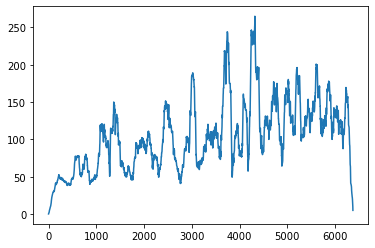

In [47]:
plt.plot(np.convolve(agent00.history['score'], np.ones(100)/100))

In [51]:
#agent.load_best()
agent0.save_video()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]

Reward: 500.0


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, observation_space, action_space, hidden_layers=[512,256],
                 policy_activation=None, activations=nn.ReLU):
        super().__init__()
        
        # Write down hidden layers dimensions
        self.hidden_layers_dimensions = hidden_layers
        self.policy_activation_ = policy_activation
        self.activations = activations
        
        # Initialize the common model
        self.model = nn.ModuleList()
        layers = [observation_space] + hidden_layers + [action_space]
        for i, layer in enumerate(layers)[1:]:
            self.model.append(nn.Linear(layers[i-1], layers[i]))
        
        # Enpoind for policy
        self.policy = nn.Linear(hidden_layers[1], action_space)
        if self.policy_activation_:
            self.policy_activation = self.policy_activation_(action_space)
        # Endpoint for values
        self.value = nn.Linear(hidden_layers[1], 1)
        
    def forward(self, x):
        # Apply common model
        for layer in self.model:
            x = self.activations(layer(x))
        # Get value output
        value = self.value(x)
        # Get policy output
        policy = self.policy(x)
        if self.policy_activation_:
            policy = self.policy_activation(policy)
        return value, policy